## Name and ID

Pierrick Lorang

Student ID: 1420789

## Comp 150 Probabilistic Robotics Homework 1:
# Kalman Filter


### Import required libraries.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean 
import copy

## 1. Kalman Filter: Prediction

### Question 1.1
<em>What is the minimal state vector for the Kalman filter so that the resulting system is Markovian?</em>

For the Markovian Property to hold, the state vector for the Kalman filter has to include all the information necessary to predict the future state based only on the current state and control inputs. Here, this means that the state vector should include the position (x) and velocity (v) of the drone.



Therefore, the minimal state vector for the Kalman filter is $X=[x, v]^T$.

### Question 1.2
<em>Design the state transition probability function $p(x_t | u_t, x_{t−1})$.The transition function should contain linear matrices A and B and a noise covariance R.</em>

Assuming delta_x is an horizontal displacement, the gravity does not impact it. By applying the second law of Newton we have the following equations of motion:

$x = x_0 + v*t + 0.5*a*t^2$ (Eq. 1)

$v = v_0 + a*t$ (Eq. 2)

With a being the acceleration of the drone.

By rewriting this equation in a state representation using the vector X as defined previously, we have: 


$X_t = A_t * X_{t-1} + B_t * u_t + \epsilon_t$ (Eq. 3)

otherwise:

$X_t = A_t * X_{t-1} + B_t * u_t + G_t * a_t$ (Eq. 4)

We note that from the problem enonciation, the control u is set to 0 initially, meaning that we can set B to a 2by2 0 matrice for now. We can also note that epsilon is the gaussian random vector that models the randomness of the wind, affecting the acceleration $a \sim \mathcal{N}(0, \sigma_\text{wind}^2=1)$. The random variable epsilon follows a gaussian distribution $\epsilon \sim \mathcal{N}(0, R)$, with $R = G*(G^T)*(\sigma_\text{wind}^2)$.

By replacing Eq.1 and Eq.2 in Eq.3 we have:

$A = [[1,d_t],[0,1]]$

$B = [[0],[0]]$

$G = [[0.5 * d_t ** 2],[d_t]]$
, and

$R = [[0.25 * (d_t^4), 0.5 * (d_t^3)],[0.5 * (d_t^3), d_t^2]] * (\sigma_\text{wind}^2)$

We then have $p(x_t | u_t, x_{t−1})$ given by equation 3.4 in the book Probabilistic Robotics using A, B and R.

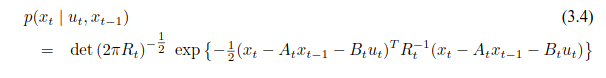



### Question 1.3
<em>Implement the state prediction step of the Kalman filter, assuming that at time t = 0, we start at rest, i.e., xt = ˙xt = ¨xt = 0.0. Use your code to calculate the state distribution for times t = 1, 2, . . . , 5.</em>

Here is the Kalman_filter Algorithm:

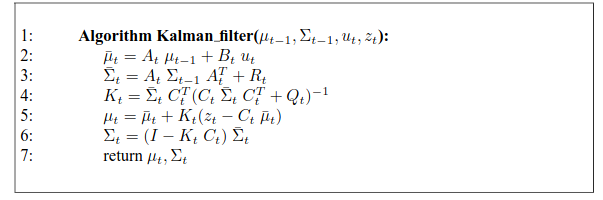

We will apply lines 1 to 3 to answer this question.

### EXTRA CREDITS 1
<strong>You can change the value delta_t to be any you wish and re-run the notebook.</strong> Please Reset the Kernel before hand.
### EXTRA CREDITS 2
<strong>You can change the value sigma_wind to be any you wish and re-run the notebook.</strong> Please Reset the Kernel before hand.

In [2]:
# Define Initial Conditions
a = 0  # Acceleration
v = 0  # Velocity
x = 0  # Position
u = 0
delta_t = 1  # Difference in time (timestep detla t)

sigma_wind = 1

# Define Required Matrices
A = np.array([[1, delta_t],
              [0, 1]])

B = np.array([[0],[0]])

G = np.array([[0.5 * delta_t ** 2],[delta_t]])

R = np.array([[0.25 * (delta_t ** 4), 0.5 * (delta_t ** 3)],
              [0.5 * (delta_t ** 3), delta_t**2]]).dot(sigma_wind)

X = np.array([[0],[0]])

COV = np.array([[0, 0],
                [0, 0]]) # Covariance Matrice, we know the exact position and velocity, 
                         # we give it a zero covariance matrix


# Kalman Filter Algorithm lines 1-3
def Kalman_filter(X, COV, u, z=None):
    X = A.dot(X) + B.dot(u) 
    COV = A.dot(COV).dot(A.T) + R
    return X, COV


# State Distribution Computation for t = [1:5]
state_distribution = (X, COV)

mean_list = list()
cov_list = list()
for t in range(1, 6):
    X, COV = state_distribution[0], state_distribution[1]
    state_distribution = Kalman_filter(X, COV, u=0)
    mean_list.append(state_distribution[0])
    cov_list.append(state_distribution[1])
    print("State Distribution for t={}: \nMean = {}, \nCovariance = {}\n".format(t, X, COV))

State Distribution for t=1: 
Mean = [[0]
 [0]], 
Covariance = [[0 0]
 [0 0]]

State Distribution for t=2: 
Mean = [[0]
 [0]], 
Covariance = [[0.25 0.5 ]
 [0.5  1.  ]]

State Distribution for t=3: 
Mean = [[0]
 [0]], 
Covariance = [[2.5 2. ]
 [2.  2. ]]

State Distribution for t=4: 
Mean = [[0]
 [0]], 
Covariance = [[8.75 4.5 ]
 [4.5  3.  ]]

State Distribution for t=5: 
Mean = [[0]
 [0]], 
Covariance = [[21.  8.]
 [ 8.  4.]]



### Question 1.4
<em>For each posterior, you are asked to plot the uncertainty ellipse which is the ellipse of points that are one standard deviation away from the mean</em>

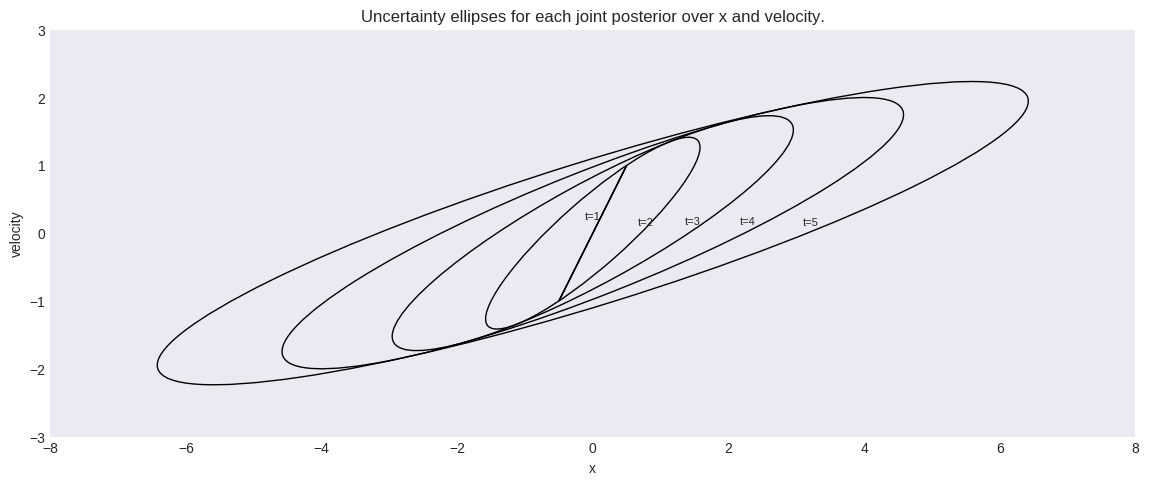

In [3]:
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
def plot_ellipse(mean_list, cov_list, t=None, xlim=8, ylim=3, labels=None, title=None):
    # Plot the ellipse
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for i in range(len(mean_list)):
        mean = mean_list[i]
        sigma = cov_list[i]
        # Compute the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(sigma)
        # Compute the angle of the ellipse
        angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
        # Compute the length of the major and minor axes
        length = np.sqrt(eigenvalues)
        ellipse = plt.matplotlib.patches.Ellipse(mean, 2 * length[0], 2 * length[1], angle=angle * 180 / np.pi, fill=False)
        ax.add_artist(ellipse)
        if t == None and labels == None:
            ax.text(mean[0] + 0.5 * length[0] * np.cos(angle), mean[1] + 0.5 * length[1] * np.sin(angle), f't={i+1}', ha='center', va='center', fontsize=8)
        elif labels != None:
            ax.text(mean[0] + 0.5 * length[0] * np.cos(angle), mean[1] + 0.5 * length[1] * np.sin(angle), f'{labels[i]}', ha='center', va='center', fontsize=8)
        else:
            ax.text(mean[0] + 0.5 * length[0] * np.cos(angle), mean[1] + 0.5 * length[1] * np.sin(angle), f't={t}', ha='center', va='center', fontsize=8)
    if xlim != None:
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
    plt.xlabel('x')
    plt.ylabel('velocity')
    if title == None:
        plt.title("Uncertainty ellipses for each joint posterior over x and velocity.")
    else:
        plt.title(title)
    plt.show()

plot_ellipse(mean_list, cov_list)

## 2. Kalman Filter: Measurement

### Question 2.1
<em>Define the measurement model. You will need to define matrices $C$ and $Q$.</em>

We have that:

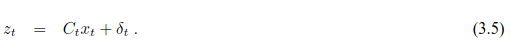

with $\delta_t$ following a multivariate Gaussian with zero mean and covariance $Q$. Thus:

$C = [1, 0]^T$ as the GPS measures in expectation the true position, and

$Q = [\sigma_\text{gps}^2] = [8.0]$

### Question 2.2
<em>Implement the measurement update. Suppose at time t = 5,
the drone’s computer has rebooted and we query our sensor for the first time to
obtain the measurement z = 10. State the parameters of the Gaussian estimate
before and after incorporating the measurement.</em>


We still have the mean and covariance estimates at time t=5 from Question 1.3. Let's reboot the computer and add the measurement z=10.

Thus, <strong>before the measurement</strong> we have:

State Distribution for t=5: 
Mean = [[0]
 [0]], 
Covariance = [[21.  8.]
 [ 8.  4.]]



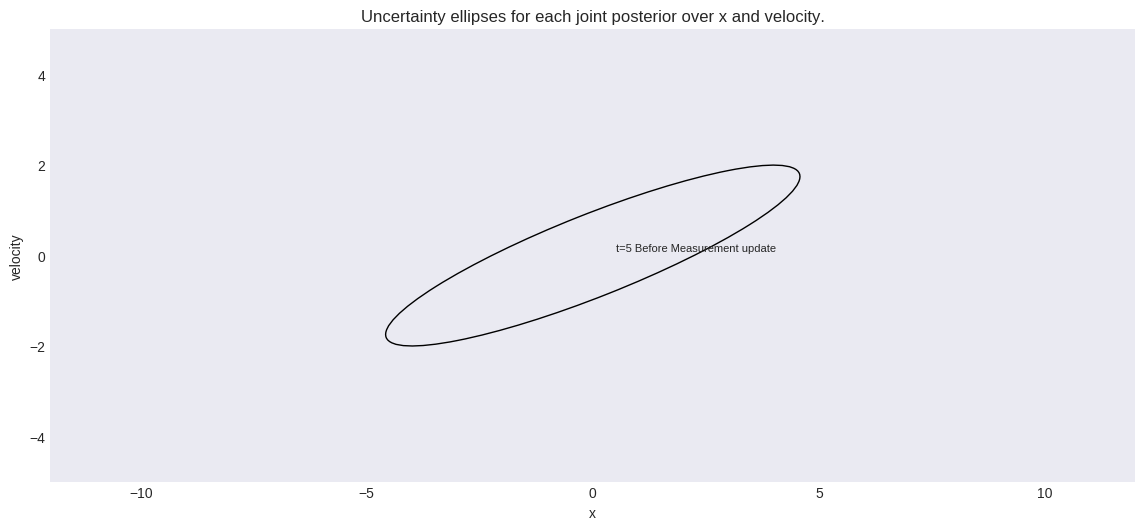

In [4]:
print("State Distribution for t={}: \nMean = {}, \nCovariance = {}\n".format(5, X, COV))
plot_ellipse([np.around(X, decimals=2)], [np.around(COV, decimals=2)], t="5 Before Measurement update", xlim=12, ylim=5)

The lines 4-7 of the Kalman Filter are the measurement update. They are coded as follows:

In [5]:
X_5 = copy.deepcopy(X)
COV_5 = copy.deepcopy(COV)

[[1 0]]
State Distribution for t=5 After Measurement Update: 
Mean = [[7.2]
 [2.8]], 
Covariance = [[5.8 2.2]
 [2.2 1.8]]



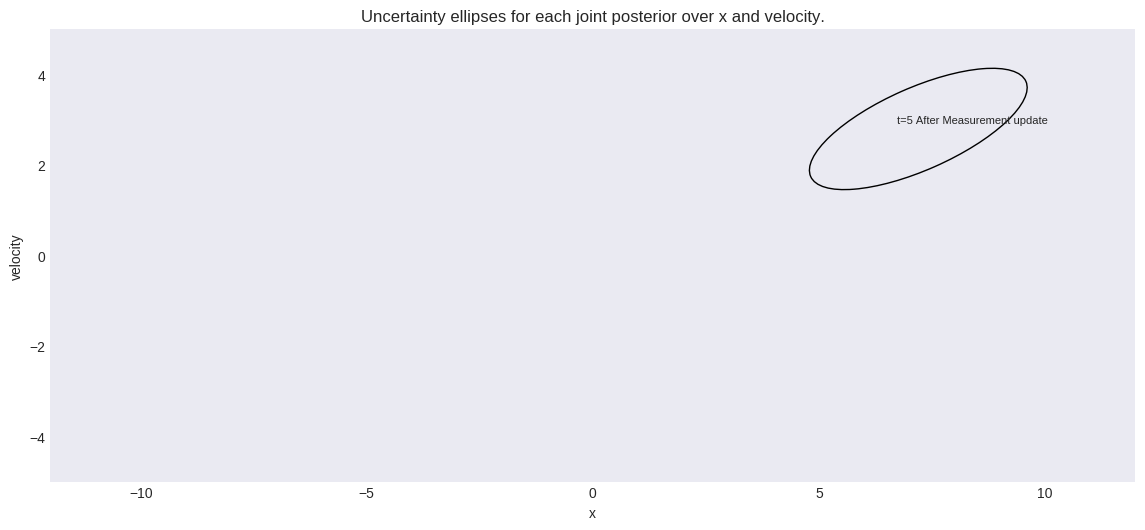

In [6]:
# Define required matrices
z = 10
C = np.array([[1], [0]]).T
print(C)
Q = np.array([8.0])


# Calculate the Kalman Gain lines 4-7
S = C.dot(COV_5).dot(C.T) + Q
K = COV_5.dot(C.T).dot(inv(S))
# Update the State Matrix
X_5_updated = X_5 + K.dot(z-C.dot(X_5))
# Update the Covariance Matrix
COV_5_updated = (np.identity(len(K)) - K.dot(C)).dot(COV_5)

# Round up the values to 1 decimal
X_5_updated = np.around(X_5_updated, decimals=1)
COV_5_updated = np.around(COV_5_updated, decimals=1)

print("State Distribution for t={}: \nMean = {}, \nCovariance = {}\n".format("5 After Measurement Update", X_5_updated, COV_5_updated))
plot_ellipse([X_5_updated], [COV_5_updated], t="5 After Measurement update", xlim=12, ylim=5)

### <strong><strong>Let's write the entire Kalman Filter function</strong>

In [7]:
# Kalman Filter Algorithm lines 1-7 (entire algorithm)
def Kalman_filter(X, COV, u, z=None):
    X = A.dot(X) + B.dot(u) 
    COV = A.dot(COV).dot(A.T) + R
    if z != None:
        # Calculate the Kalman Gain
        S = C.dot(COV).dot(C.T) + Q
        K = COV.dot(C.T).dot(inv(S))
        # Update the State Matrix
        X = X + K.dot(z-C.dot(X))
        # Update the Covariance Matrix
        COV = (np.identity(len(K)) - K.dot(C)).dot(COV)
        
    return X, COV

<em>Afterwards, implement the
sensor modal to randomly sample the true position, corrupted with noise σ2
gps.</em>
### <strong><strong>Let's write the environment class</strong>

In [8]:
class Environment:
    def __init__(self, prob_gps_fail=0, sigma_square_noise_gps=8, init_X=np.array([[0],[0]])):
        self.prob_gps_fail = prob_gps_fail
        self.std_noise_gps = np.sqrt(sigma_square_noise_gps)
        self.init_X = init_X
    
    def reset(self):
        self.X = self.init_X
        self.X_measured = self.init_X
    
    def step(self, control):
        if np.random.random() > self.prob_gps_fail:
            # EXTRA: can change sigma_wind at the begining of the notebook
            accel_wind = np.random.normal(loc=0.0, scale=sigma_wind) # loc is the mean, scale is the std
            # Equation of motion. True value of X.
            X = A.dot(self.X) + B.dot(control) + G.dot(accel_wind)
            self.X = X
            # Add noise
            noise = np.random.normal(loc=0.0, scale=self.std_noise_gps)
            z_measured = X[0][0] + noise
            self.X_measured = np.array([[z_measured],[X[1][0]]])
            return z_measured
        else:
            return None
    
    def get_true_measured_X(self):
        return self.X_measured
    
    def get_true_X(self):
        return self.X

### Question 2.3
<em>All of a sudden, the sky gets cloudy which may cause the
sensor to fail and not produce a measurement with probability pgps−f ail. For
three different values of this probability (e.g., 0.1, 0.5, and 0.9), compute and
plot the expected error from the true position at time t = 20. You may do so by
running up to N simulations and use the observed errors to obtain the expected
error empirically.</em>

Expected Error for p_gps_failure 0.1: 1.97


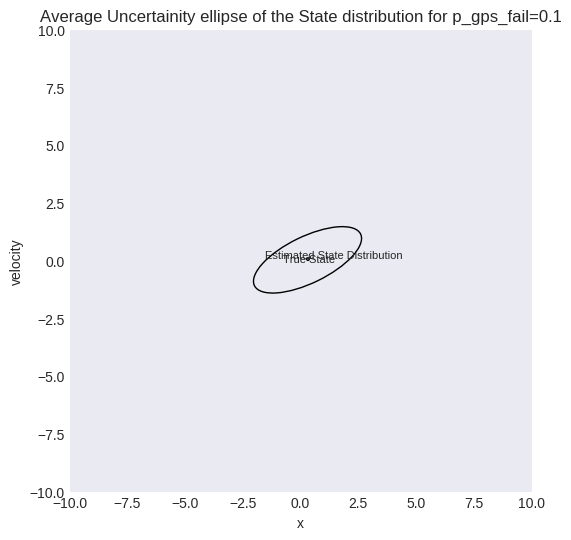

Expected Error for p_gps_failure 0.5: 2.8


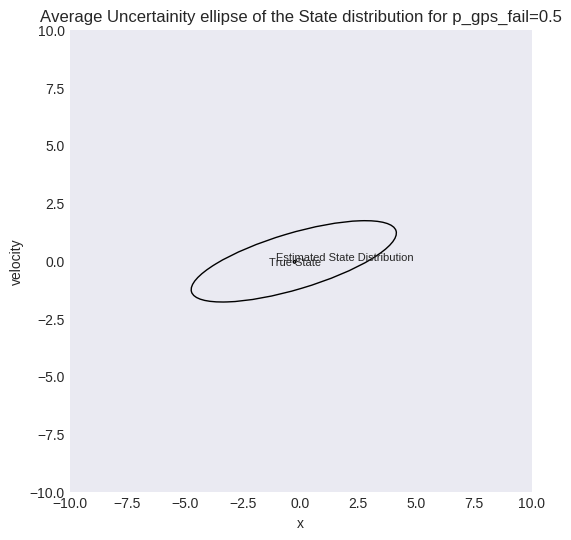

Expected Error for p_gps_failure 0.9: 4.35


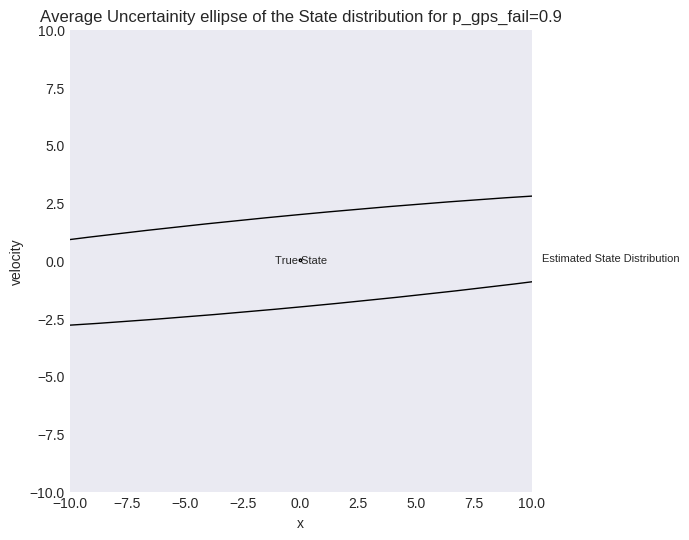

In [9]:
probas_failure = [0.1, 0.5, 0.9]

number_simulations = 10000

# Experiment loop through gps_failure_proba, number of simulation per gps_failure_proba and 20 time steps
for prob in probas_failure:
    obs_errors = list()
    X_list = list()
    COV_list = list()
    X_true_list = list()
    for n in range(0, number_simulations): # N simulations loop
        # Re-Initialize the state space
        X = np.array([[0],[0]])

        COV = np.array([[0, 0],
                        [0, 0]])

        env = Environment(prob_gps_fail=prob)
        env.reset()
        for t in range(0,20): # timesteps loop
            z_measured = env.step(control=0)
            X, COV = Kalman_filter(X, COV, u=0, z=z_measured)
        true_X = env.get_true_X()
        true_COV = np.array([[0.003, 0],[0, 0.003]]) # very small numbers just to hack a mean point in the graph
        obs_errors.append(abs(X[0][0]-true_X[0][0]).astype(np.float64))
        X_list.append(X)
        X_true_list.append(true_X)
        COV_list.append(COV)
    avg_X = np.mean(X_list, axis=0)
    avg_true_X = np.mean(X_true_list, axis=0)
    avg_COV = np.mean(COV_list, axis=0)
    print("Expected Error for p_gps_failure {}: {}".format(prob, np.around(mean(obs_errors), decimals=2)))
    plot_ellipse([avg_X, avg_true_X], [avg_COV, true_COV], title="Average Uncertainity ellipse of the State distribution for p_gps_fail={}".format(prob), labels=["Estimated State Distribution", "True State"], xlim=10, ylim=10)

## 3. Kalman Filter: Movement

### Question 3.1
<em>The drone is now fully operational and can not only take measurements, but also issue motor commands in the form of acceleration commands to its propeller. For example, a command of 1.0 will increase the drone’s velocity by 1.0. Revisit Question 1.3 to provide the matrix $B$. If at time t − 1,
the drone’s position and velocity are 5.0 and 1.0, compute the mean estimate
for the state at time t given a motor command of 1.0. Your answer should be
based on the constants provided but also include a random variable due to the
wind effects. State the distribution of that random variable.</em>

We still have the following equations:

$x = x_0 + v*t + 0.5*a*t^2$

$v = v_0 + a*t$ 

Except now the acceleration of the drone an be decomposed into a random acceleration due to the wind and a command input acceleration u.

We thus have

$X_t = A_t * X_{t-1} + B_t * u_t + \epsilon_t$ (Eq. 3)

with:

$B = [[0.5 * d_t ** 2],[d_t]]$

In [10]:
# Overwrite B
B = np.array([[0.5 * delta_t ** 2],[delta_t]])

# Initial state according to the question
X = np.array([[5],[1]])

COV = np.array([[0, 0],
                [0, 0]])

#### Kalman filter pass but now with u=1, the wind effect is included in the function

First Without measurement:

In [11]:
X_update, COV_update = Kalman_filter(X, COV, u=1, z=None)
print("Mean estimate for the state at time t (after one time step without measurement): position={}, velocity={}".format(X_update[0][0], X_update[1][0]))

Mean estimate for the state at time t (after one time step without measurement): position=6.5, velocity=2.0


Now With environment measurement:

In [12]:
env = Environment(prob_gps_fail=0)
env.reset()
z_measured = env.step(control=1)
X_update, COV_update = Kalman_filter(X, COV, u=1, z=z_measured)
print("Mean estimate for the state at time t (after one time step without measurement): position={}, velocity={}".format(X_update[0][0], X_update[1][0]))

Mean estimate for the state at time t (after one time step without measurement): position=6.25198907406916, velocity=1.5039781481383203
